This is to load data, clean, and merge the two open and blind experiment datasets.

EDA, feature scaling/normalization

Train/test split

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots a bit prettier
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (6, 4)

In [2]:
path_exp1 = "C:/Users/melod/Desktop/CMOR 438/data/tampered_labels_exp1.csv"
path_exp2 = "C:/Users/melod/Desktop/CMOR 438/data/tampered_labels_exp2.csv"

exp1 = pd.read_csv(path_exp1)
exp2 = pd.read_csv(path_exp2)

exp1.head(), exp2.head()

(  type  uuid  slice    x    y
 0   FB  1280    100  323  381
 1   FB  1009     76  354  288
 2   FB  7794     79  163  191
 3   FB  7794     94  338  243
 4   FB  2997     45  156  135,
   type  uuid  slice    x    y
 0   FB  1251    150  418  350
 1   FB  1251    188  402  294
 2   FB  1251    272  163  298
 3   FB  2592    163  230  322
 4   FB  1876    146  414  181)

In [3]:
print("Experiment 1:")
display(exp1.info())
display(exp1["type"].value_counts())

print("\nExperiment 2:")
display(exp2.info())
display(exp2["type"].value_counts())


Experiment 1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    133 non-null    object
 1   uuid    133 non-null    int64 
 2   slice   133 non-null    int64 
 3   x       133 non-null    int64 
 4   y       133 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 5.3+ KB


None

type
FB    61
FM    34
TM    23
TB    15
Name: count, dtype: int64


Experiment 2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    36 non-null     object
 1   uuid    36 non-null     int64 
 2   slice   36 non-null     int64 
 3   x       36 non-null     int64 
 4   y       36 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.5+ KB


None

type
TM    12
FB    11
FM     7
TB     6
Name: count, dtype: int64

Combine the two experiments into one dataframe

Add a new column labelling which experiment it was

Experiment 1: 1
Expriment 2: 2

This way we can consider if knowledge bias comes in play

In [4]:
exp1["experiment"] = 1  # blind trial 
exp2["experiment"] = 2  # open trial

exp1.head(), exp2.head()

(  type  uuid  slice    x    y  experiment
 0   FB  1280    100  323  381           1
 1   FB  1009     76  354  288           1
 2   FB  7794     79  163  191           1
 3   FB  7794     94  338  243           1
 4   FB  2997     45  156  135           1,
   type  uuid  slice    x    y  experiment
 0   FB  1251    150  418  350           2
 1   FB  1251    188  402  294           2
 2   FB  1251    272  163  298           2
 3   FB  2592    163  230  322           2
 4   FB  1876    146  414  181           2)

In [5]:
df = pd.concat([exp1, exp2], ignore_index=True)
df.head()

,type,uuid,slice,x,y,experiment
0,FB,1280,100,323,381,1
1,FB,1009,76,354,288,1
2,FB,7794,79,163,191,1
3,FB,7794,94,338,243,1
4,FB,2997,45,156,135,1


Create a binary "tampered" label
Tampered = 1 (FB, FM)
Real = 0 (TB, TM)

In [6]:
tampered_map = {
    "FB": 1,
    "FM": 1,
    "TB": 0,
    "TM": 0,
}

df["tampered"] = df["type"].map(tampered_map)
df[["type", "tampered"]].head(10)

,type,tampered
0,FB,1
1,FB,1
2,FB,1
3,FB,1
4,FB,1
5,FB,1
6,FB,1
7,FB,1
8,FB,1
9,FB,1


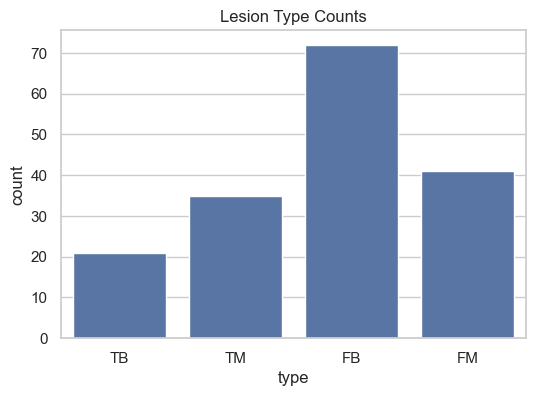

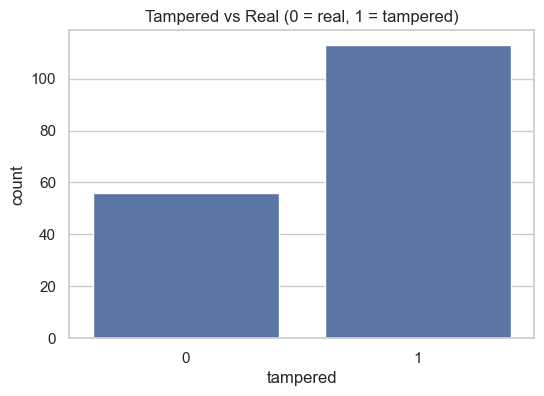

In [7]:
#Sanity check 
#Class distribution
sns.countplot(data=df, x="type", order=["TB", "TM", "FB", "FM"])
plt.title("Lesion Type Counts")
plt.show()

sns.countplot(data=df, x="tampered")
plt.title("Tampered vs Real (0 = real, 1 = tampered)")
plt.show()


In [8]:
#Coordinate ranges
df[["slice", "x", "y"]].describe()


,slice,x,y
count,169.000000,169.000000,169.000000
mean,118.686391,220.076923,252.769231
std,101.237474,135.739421,112.368495
min,0.000000,0.000000,0.000000
25%,54.000000,125.000000,214.000000
50%,92.000000,186.000000,284.000000
75%,159.000000,354.000000,329.000000
max,504.000000,476.000000,403.000000


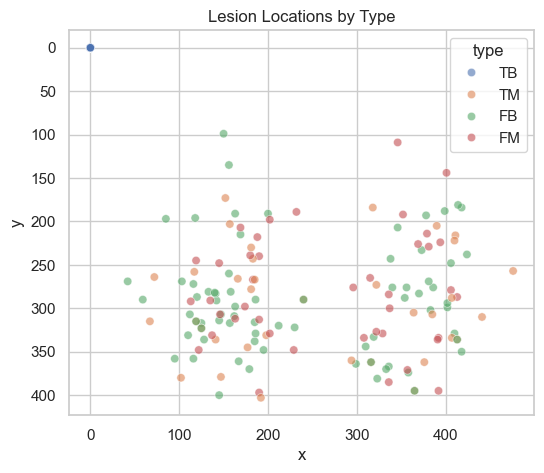

In [9]:
#Where lesions are
#By type
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="type",
    alpha=0.6,
    hue_order=["TB", "TM", "FB", "FM"],
)
plt.title("Lesion Locations by Type")
plt.gca().invert_yaxis()  #Iverted y for CT images
plt.show()


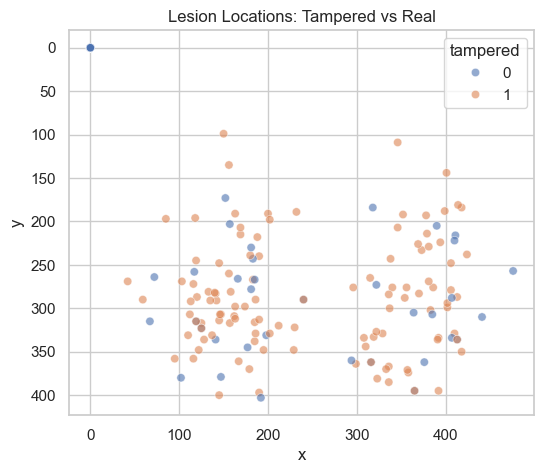

In [10]:
#Tampered
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="tampered",
    alpha=0.6,
)
plt.title("Lesion Locations: Tampered vs Real")
plt.gca().invert_yaxis()
plt.show()


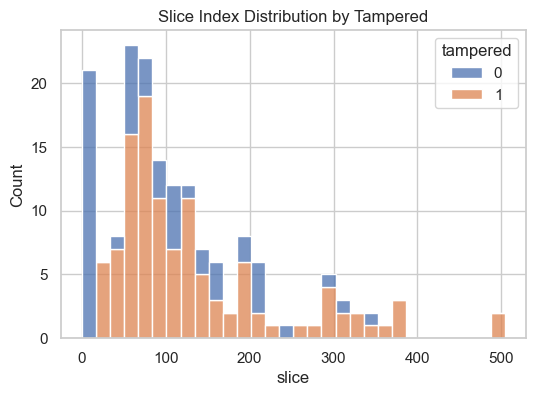

In [11]:
#Slice depth
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x="slice", hue="tampered", bins=30, kde=False, multiple="stack")
plt.title("Slice Index Distribution by Tampered")
plt.show()


In [12]:
#Normalize
max_x = df["x"].max()
max_y = df["y"].max()
max_slice = df["slice"].max()

df["x_norm"] = df["x"] / max_x
df["y_norm"] = df["y"] / max_y
df["slice_norm"] = df["slice"] / max_slice

# Distance from (0, 0) in image
df["r_xy"] = np.sqrt(df["x"]**2 + df["y"]**2)

# Quadrants
df["quad_x"] = (df["x"] > max_x / 2).astype(int)
df["quad_y"] = (df["y"] > max_y / 2).astype(int)

df.head()


,type,uuid,slice,x,y,experiment,tampered,x_norm,y_norm,slice_norm,r_xy,quad_x,quad_y
0,FB,1280,100,323,381,1,1,0.678571,0.945409,0.198413,499.489740,1,1
1,FB,1009,76,354,288,1,1,0.743697,0.714640,0.150794,456.355125,1,1
2,FB,7794,79,163,191,1,1,0.342437,0.473945,0.156746,251.097591,0,0
3,FB,7794,94,338,243,1,1,0.710084,0.602978,0.186508,416.284758,1,1
4,FB,2997,45,156,135,1,1,0.327731,0.334988,0.089286,206.303175,0,0


In [13]:
#Define feature set 
feature_cols = [
    "x_norm",
    "y_norm",
    "slice_norm",
    "r_xy",
    "quad_x",
    "quad_y",
    "experiment",
]

target_col = "tampered"

print("Features:", feature_cols)
print("Target:", target_col)


Features: ['x_norm', 'y_norm', 'slice_norm', 'r_xy', 'quad_x', 'quad_y', 'experiment']
Target: tampered


In [14]:
#Save for later
processed = df[feature_cols + [target_col, "type", "uuid", "slice", "x", "y"]].copy()
processed.to_csv("../data/lesions_processed.csv", index=False)
processed.head()


,x_norm,y_norm,slice_norm,r_xy,quad_x,quad_y,experiment,tampered,type,uuid,slice,x,y
0,0.678571,0.945409,0.198413,499.489740,1,1,1,1,FB,1280,100,323,381
1,0.743697,0.714640,0.150794,456.355125,1,1,1,1,FB,1009,76,354,288
2,0.342437,0.473945,0.156746,251.097591,0,0,1,1,FB,7794,79,163,191
3,0.710084,0.602978,0.186508,416.284758,1,1,1,1,FB,7794,94,338,243
4,0.327731,0.334988,0.089286,206.303175,0,0,1,1,FB,2997,45,156,135
